#Imports and Installation

In [1]:
pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git


  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-9_03exjz
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-9_03exjz
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 16.2 MB/s eta 0:00:00
  Created wheel for text-flappy-bird-gym: filename=text_flappy_bird_gym-0.1.1-py3-none-any.whl size=7772 sha256=673ba59564105366b84c22c0ef321e7c9e2853c40524f79d05ad90af943371ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-m2fibxaa/wheels/41/44/75/c67b96ba782472d8cacb00e3af57e29d1ee3a14f2e95a59ce5
Successfully built text-flappy-bird-gym


In [2]:
import os, sys
import gymnasium as gym

import text_flappy_bird_gym

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

from tqdm import tqdm
from tabulate import tabulate
from collections import defaultdict

#Monte Carlo Implementation

In [ ]:
class MonteCarlo:
    def __init__(self, gamma, epsilon=0.1):
        """
        Initialize the Monte Carlo agent.

        Args:
            env (gym.Env): The environment to use.
            gamma (float): The discount factor.
            n_episodes (int): The number of episodes to train for.
            epsilon (float): The probability of selecting a random action.
        """

        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: 0)
        self.N = defaultdict(lambda: 0)

    def choose_action(self, state):
        """
        Choose an action to take given a state.

        Args:
            state: The current state.

        Returns:
            The chosen action.
        """

        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(2)
        else:
            return np.argmax([self.Q[(state,0)],self.Q[(state,1)]])
    def update_Q(self, episode):
        """
        Update the Q values given an episode.

        Args:
            episode: The episode to use for updating.

        Returns:
            None.
        """

        G = 0
        visited = set()
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = self.gamma * G + reward
            if (state, action) not in visited:
                self.N[(state, action)] += 1
                self.Q[(state, action)] += (G - self.Q[state, action]) / self.N[state, action]
                visited.add((state, action))
    def train(self,env, n_episodes):
        """Train the agent (include both exploration and exploitation)
        Args:
            env (gym.env): the environment
            num_episodes (int): the number of episodes to train the agent on

        Returns:
            rewards (list): list of the sum of rewards obtained for each episode
            scores (list) : list of the scores obtained for each episode
        """
        rewards = []
        scores=[]
        for i in tqdm(range(n_episodes)):
            state,_ = env.reset()
            done = False
            episode = []
            episode_reward = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward,done,_, info = env.step(action)
                episode.append((state, action, reward))
                episode_reward += reward
                state = next_state
            self.update_Q(episode)
            rewards.append(episode_reward)
            scores.append(info['score'])
        return rewards,scores
    def test(self,env, n_episodes):
        """Test the agent (include only exploitation)
        Args:
            env (gym.env): the environment
            num_episodes (int): the number of episodes to train the agent on

        Returns:
            rewards (list): list of the sum of rewards obtained for each episode
            scores (list): list of the scores obtained for each episode
        """
        rewards = []
        scores=[]
        for i in tqdm(range(n_episodes)):
            state,_ = env.reset()
            done = False
            episode_reward = 0
            while not done:
                action = np.argmax([self.Q[state,0],self.Q[state,1]])
                next_state, reward,done,_, info = env.step(action)
                episode_reward += reward
                state = next_state
                if info['score'] >1e5: #Stopping condition to avoid it to be stuck if it never dies
                    break
            rewards.append(episode_reward)
            scores.append(info['score'])
        return rewards,scores


100%|██████████| 10000/10000 [00:06<00:00, 1433.03it/s]


Average reward over 10000 train episodes: 21.4594
Median reward over 10000 train episodes: 13.0
Average scores over 10000 train episodes: 0.9212
Median scores over 10000 train episodes: 0.0


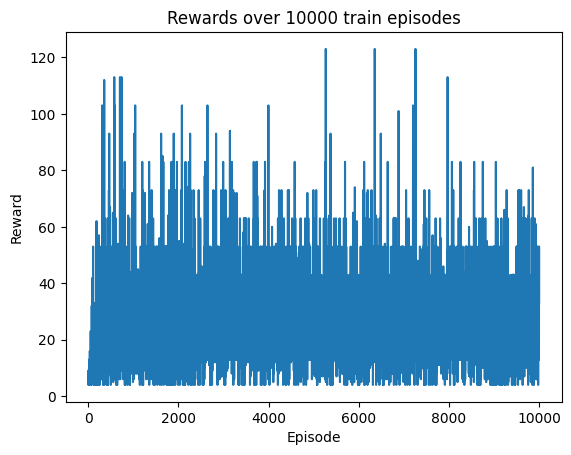

In [ ]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)


n_episodes = 10000
# create the Monte Carlo agent
mc_agent = MonteCarlo(gamma=0.5, epsilon=0.5)

# train the Monte Carlo agent
train_rewards, train_scores = mc_agent.train(env,n_episodes)

print(f"Average reward over {n_episodes} train episodes:", np.mean(train_rewards))
print(f"Median reward over {n_episodes} train episodes:", np.median(train_rewards))
print(f"Average scores over {n_episodes} train episodes:", np.mean(train_scores))
print(f"Median scores over {n_episodes} train episodes:", np.median(train_scores))


# plot the rewards
plt.plot(train_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} train episodes")
plt.show()

# plot the scores
plt.plot(train_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} train episodes")
plt.show()

#Hyperparameter Tuning for the Monte Carlo

In [ ]:
labels = ["epsilon = 0.1", "epsilon = 0.2","epsilon = 0.3", "epsilon = 0.4","epsilon = 0.5", "epsilon = 0.6", "epsilon = 0.7"]
epsilon = [0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.7]



all_scores=[]
all_rewards=[]
for eps in epsilon:
    n_episodes = 10000
    # create the Monte Carlo agent
    mc_agent = MonteCarlo(gamma=0.5, epsilon=eps)

    # train the Monte Carlo agent
    train_rewards, train_scores = mc_agent.train(env,n_episodes)
    all_scores.append(train_scores)
    all_rewards.append(train_rewards)

100%|██████████| 10000/10000 [00:05<00:00, 1923.46it/s]


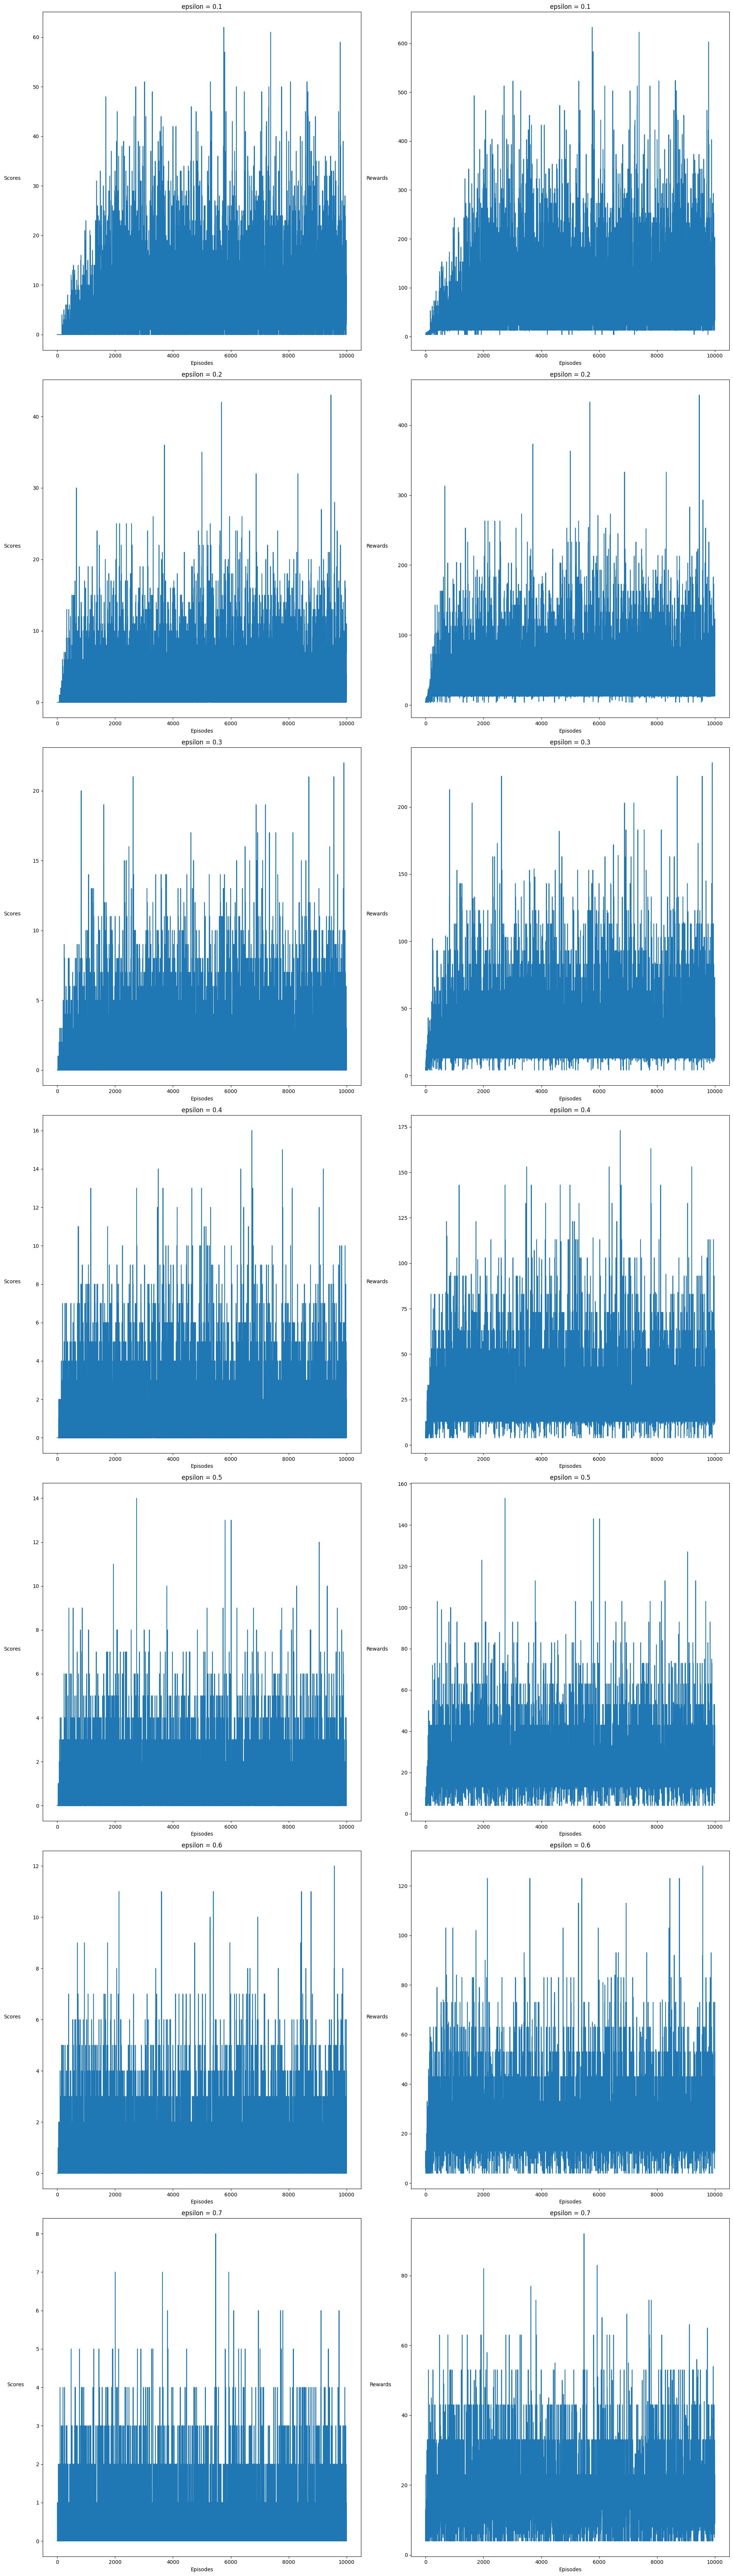

In [ ]:
# Define the number of rows and columns
num_rows = len(labels)
num_cols = 2

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10*num_rows))

# Plot the scores and rewards for each row
for i in range(num_rows):
    # Plot the scores
    axs[i, 0].plot(all_scores[i])
    axs[i, 0].set_xlabel("Episodes")
    axs[i, 0].set_ylabel("Scores", rotation=0, labelpad=40)
    axs[i, 0].set_title(labels[i])

    # Plot the rewards
    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("Episodes")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plots
plt.show()

In [ ]:
labels = ["Gamma = 0.5", "Gamma = 0.6", "Gamma = 0.7","Gamma = 0.8","Gamma = 0.9","Gamma = 0.9999"]
gamma = [0.5, 0.6, 0.7,0.8,0.9,0.9999]

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

all_scores=[]
all_rewards=[]
for gam in gamma:
    n_episodes = 10000
    # create the Monte Carlo agent
    mc_agent = MonteCarlo(gamma=gam, epsilon=0.1)

    # train the Monte Carlo agent
    train_rewards, train_scores = mc_agent.train(env,n_episodes)
    all_scores.append(train_scores)
    all_rewards.append(train_rewards)

100%|██████████| 10000/10000 [00:22<00:00, 445.79it/s]


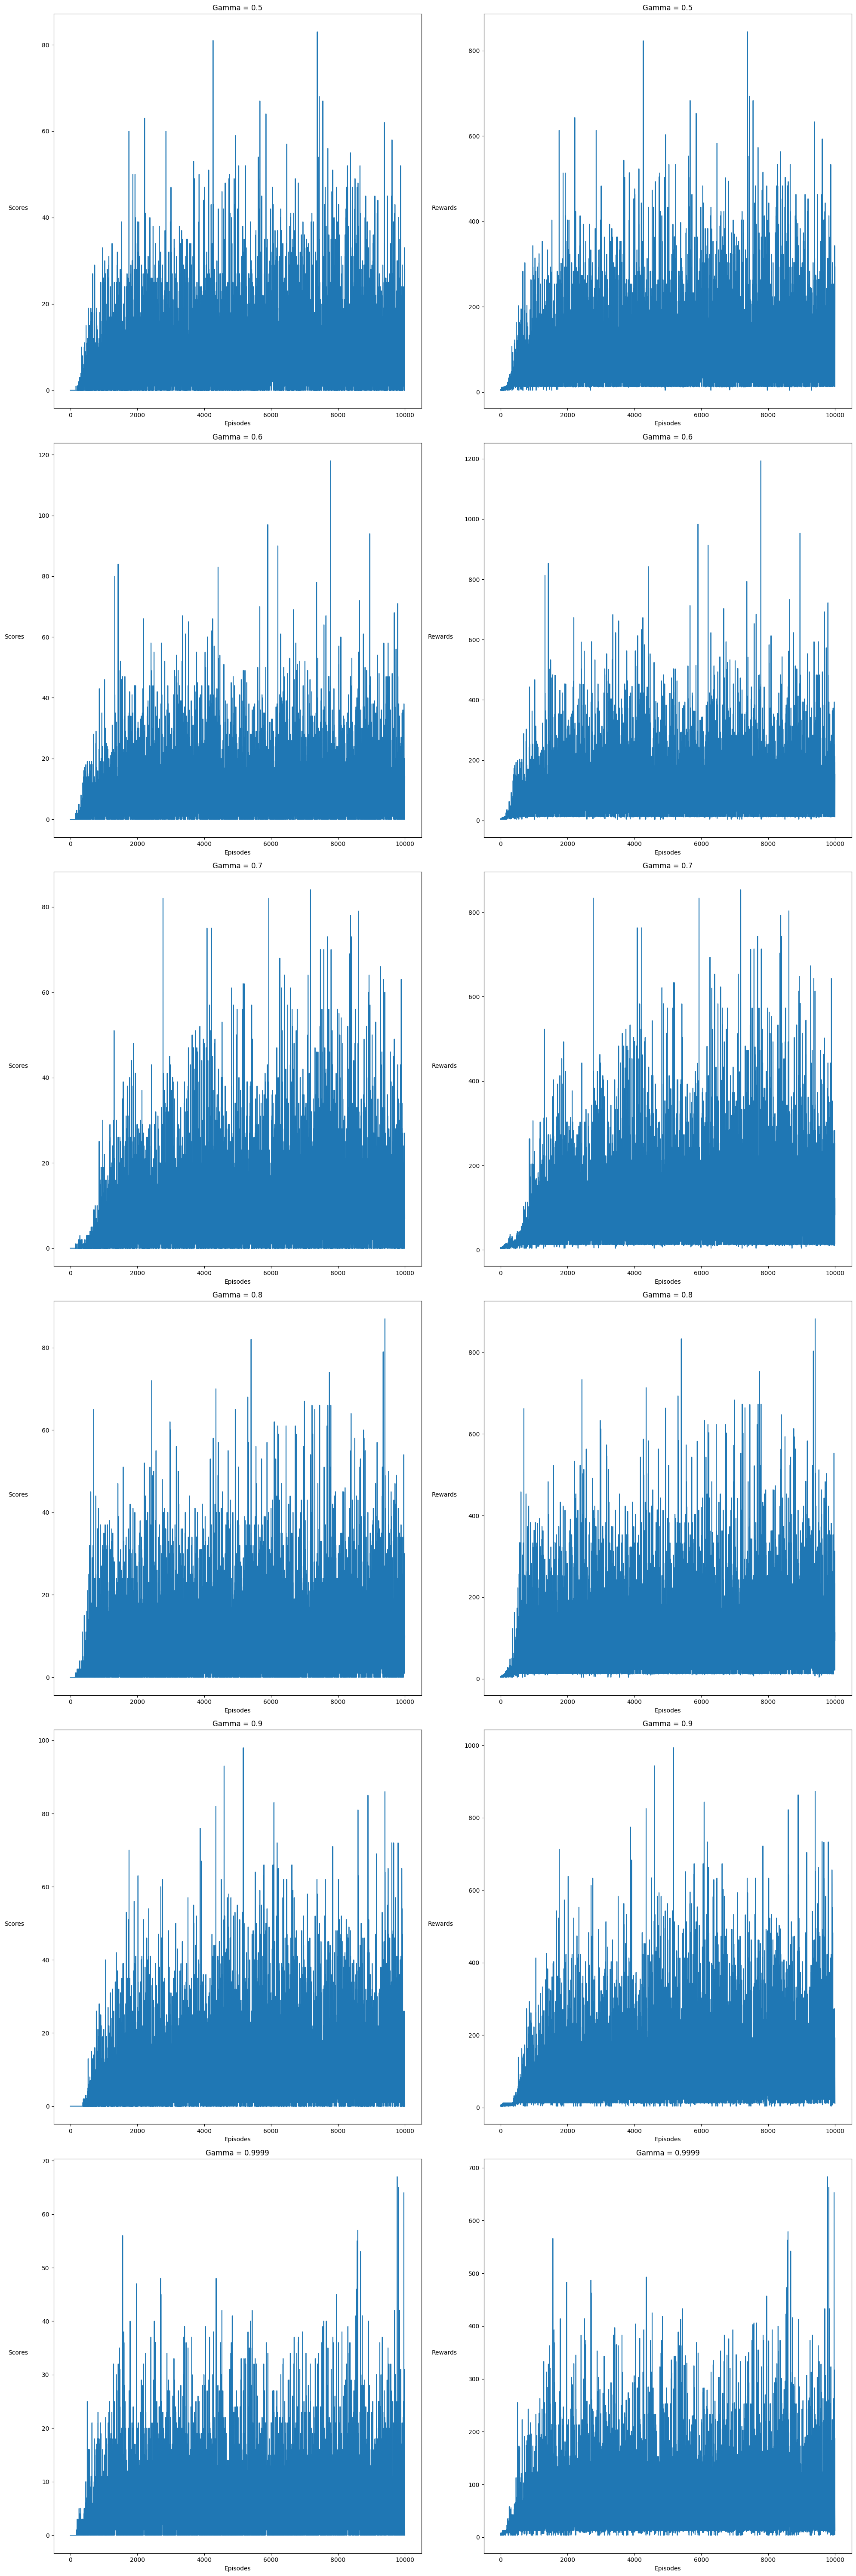

In [ ]:
# Define the number of rows and columns
num_rows = len(labels)
num_cols = 2

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10*num_rows))

# Plot the scores and rewards for each row
for i in range(num_rows):
    # Plot the scores
    axs[i, 0].plot(all_scores[i])
    axs[i, 0].set_xlabel("Episodes")
    axs[i, 0].set_ylabel("Scores", rotation=0, labelpad=40)
    axs[i, 0].set_title(labels[i])

    # Plot the rewards
    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("Episodes")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plots
plt.show()

100%|██████████| 20000/20000 [01:17<00:00, 256.73it/s]


Average reward over 20000 train episodes: 113.60905
Median reward over 20000 train episodes: 83.0
Average scores over 20000 train episodes: 10.1523
Median scores over 20000 train episodes: 7.0


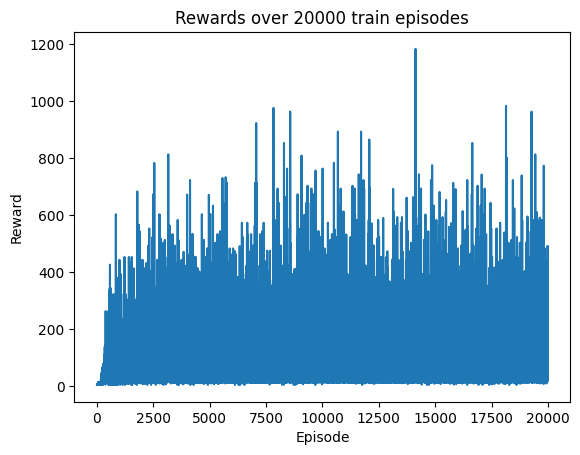

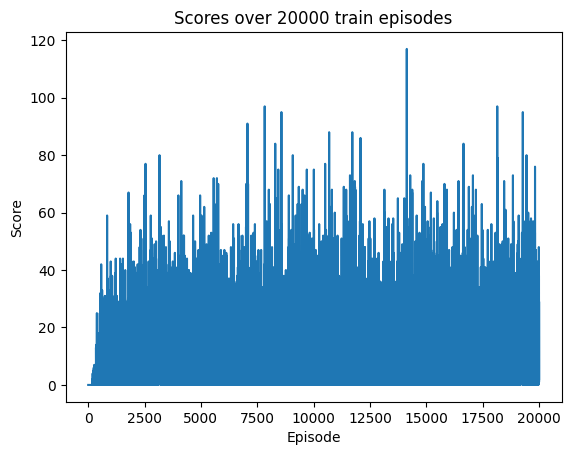

In [ ]:
n_episodes = 20000
# create the Monte Carlo agent
mc_agent = MonteCarlo(gamma=0.9, epsilon=0.1)

# train the Monte Carlo agent
train_rewards, train_scores = mc_agent.train(env,n_episodes)

print(f"Average reward over {n_episodes} train episodes:", np.mean(train_rewards))
print(f"Median reward over {n_episodes} train episodes:", np.median(train_rewards))
print(f"Average scores over {n_episodes} train episodes:", np.mean(train_scores))
print(f"Median scores over {n_episodes} train episodes:", np.median(train_scores))


# plot the rewards
plt.plot(train_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} train episodes")
plt.show()

# plot the scores
plt.plot(train_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} train episodes")
plt.show()

100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Average reward over 100 test episodes: 17162.3
Median reward over 100 test episodes: 12862.0
Average scores over 100 test episodes: 1715.53
Median scores over 100 test episodes: 1285.5


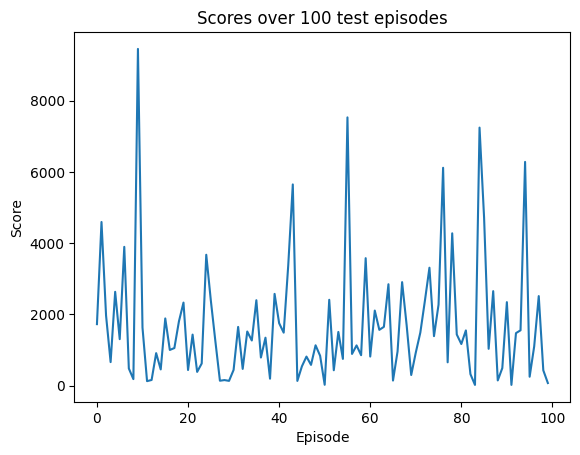

In [ ]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
n_episodes=100
test_rewards,test_scores = mc_agent.test(env,n_episodes)
print(f"Average reward over {n_episodes} test episodes:", np.mean(test_rewards))
print(f"Median reward over {n_episodes} test episodes:", np.median(test_rewards))
print(f"Average scores over {n_episodes} test episodes:", np.mean(test_scores))
print(f"Median scores over {n_episodes} test episodes:", np.median(test_scores))


# plot the rewards
plt.plot(test_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} test episodes")
plt.show()

# plot the scores
plt.plot(test_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} test episodes")
plt.show()

In [ ]:
# Set up a list of episodes to test
num_episodes_list = [1000, 2000, 3000, 4000, 5000]

# Set up a list to store the average scores/rewards
avg_scores = []
avg_rewards= []

# Loop through each episode count
for num_episodes in num_episodes_list:

    # Initialize the environment
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

    # Train the Monte Carlo agent on the specified number of episodes
    mc_agent = MonteCarlo(gamma=0.9, epsilon=0.1)
    mc_agent.train(env,num_episodes)

    # Test the agent on the test set
    test_rewards,test_scores = mc_agent.test(env,10)

    # Calculate the average score for the test set
    avg_score = np.mean(test_scores)
    avg_reward = np.mean(test_rewards)

    # Add the average score/reward to the list
    avg_scores.append(avg_score)
    avg_rewards.append(avg_reward)

100%|██████████| 10/10 [00:01<00:00,  9.06it/s]


#Parameter Sweep Graphs for Monte Carlo

In [ ]:
# Plot the parameter sweep graph
plt.plot(num_episodes_list, avg_scores)
# plt.plot(num_episodes_list, avg_rewards)
plt.xlabel("Number of Episodes during Training")
plt.ylabel("Average Score on Test Set")
plt.title("Impact of Number of Episodes during Training on Monte Carlo Agent Performance", pad=20)
plt.show()

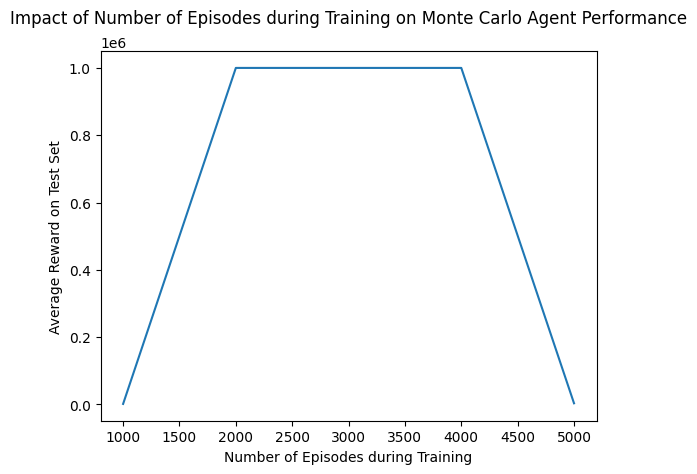

In [ ]:
# Plot the parameter sweep graph
plt.plot(num_episodes_list, avg_rewards)
plt.xlabel("Number of Episodes during Training")
plt.ylabel("Average Reward on Test Set")
plt.title("Impact of Number of Episodes during Training on Monte Carlo Agent Performance", pad=20)
plt.show()

In [ ]:
# Set up a list of pipe gap to test
pipe_gap_list = [1, 2, 3,4,5,6,7]

# Set up a list to store the average scores/rewards
avg_scores = []
avg_rewards= []

# Train the MC agent on a training environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
mc_agent = MonteCarlo(gamma=0.9, epsilon=0.1)
mc_agent.train(env,4000)

# Loop through each pipe gap
for pipe_gap in pipe_gap_list:

    # Initialize the environment with the pipe gap
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=pipe_gap)

    # Test the agent on the test set
    test_rewards,test_scores = mc_agent.test(env,10)

    # Calculate the average score for the test set
    avg_score = np.mean(test_scores)
    avg_reward = np.mean(test_rewards)

    # Add the average score/reward to the list
    avg_scores.append(avg_score)
    avg_rewards.append(avg_reward)

100%|██████████| 10/10 [03:42<00:00, 22.20s/it]


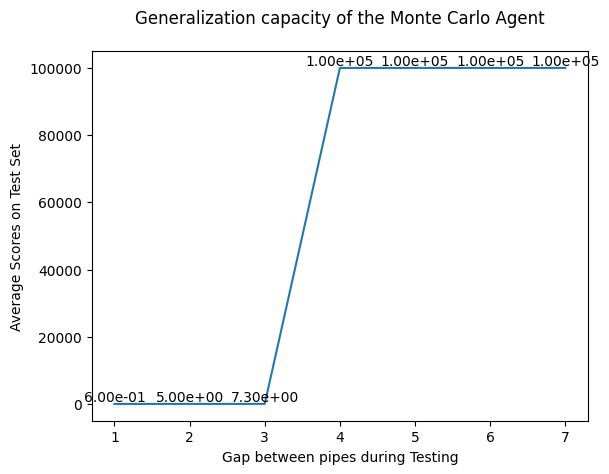

In [ ]:
# Plot the parameter sweep graph
plt.plot(pipe_gap_list, avg_scores)
plt.xlabel("Gap between pipes during Testing")
plt.ylabel("Average Scores on Test Set")
plt.title("Generalization capacity of the Monte Carlo Agent", pad=20)

# Add value for each point
for x, y in zip(pipe_gap_list, avg_scores):
    plt.text(x, y, f"{y:.2e}", ha="center", va="bottom")


plt.show()

#State Value Graph for Monte Carlo

In [ ]:
def get_statevalue(x, y, Q):
    """
    Calculates the state-value function for a given state (x,y) using the Q-table.

    Args:
        x (int): x-coordinate of the state
        y (int): y-coordinate of the state
        Q (dict): Q-table containing state-action values

    Returns:
        float: state-value function for the given state (x,y)
    """
    state = (x, y)
    returns = []
    actions = [0, 1]  # Possible actions in the game

    # Loop over all possible actions and calculate their returns
    for action in actions:
        next_state = ((x+1, y+1),action)  # The next state after taking the given action
        if next_state in list(Q.keys()):
            returns.append(Q[next_state])
        else:
            returns.append(0.0)

    # Calculate the state-value as the average of the returns
    if len(returns) > 0:
        state_value = np.mean(returns)
    else:
        state_value = 0.0

    return state_value

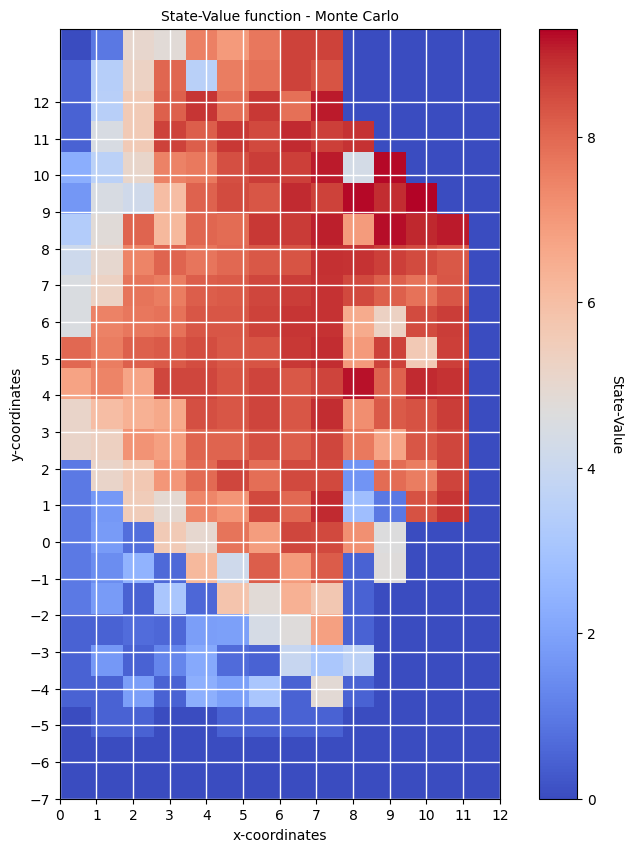

In [ ]:
# Get the range of x/y-axis for the plot
x_values_MC = []
y_values_MC = []
for state in mc_agent.Q.keys():
    x = state[0][0]
    y = state[0][1]
    if x not in x_values_MC:
        x_values_MC.append(x)
    if y not in y_values_MC:
        y_values_MC.append(y)
# Prepare the plot
x_range = sorted(x_values_MC)
y_range = sorted(y_values_MC)

X, Y = np.meshgrid(x_range, y_range)
Z = np.array([[get_statevalue(x, y, mc_agent.Q) for x in x_range] for y in y_range])

# Generate the plot
plt.figure(figsize=(10, 10))
plt.xticks(x_range)
plt.yticks(y_range)
surf = plt.imshow(Z, cmap=plt.get_cmap('coolwarm'), extent=[0, 12, -7, 14])
plt.title('State-Value function - Monte Carlo', fontsize='medium')
plt.xlabel('x-coordinates')
plt.ylabel('y-coordinates')
plt.grid(color='w', linestyle='-', linewidth=1)
cbar = plt.colorbar(surf)
cbar.ax.set_ylabel('State-Value', rotation=270, labelpad=20)
plt.show()

In [ ]:
def get_optimal_action(x, y, Q):
    """
    Calculates the optimal action for a given state (x,y) using the Q-table.

    Args:
        x (int): x-coordinate of the state
        y (int): y-coordinate of the state
        Q (dict): Q-table containing state-action values

    Returns:
        int: the optimal action (0 or 1) for the given state (x,y)
    """
    state = (x, y)
    actions = [0, 1]  # Possible actions in the game
    action_values = []

    # Calculate the action-values for each possible action
    for action in actions:
        next_state = ((x+1, y+1),action)  # The next state after taking the given action
        if next_state in list(Q.keys()):
            action_values.append(Q[next_state])
        else:
            action_values.append(0.0)

    # Return the optimal action based on the action-values
    if action_values[0]==0 and action_values[1]==0:
        return -1
    elif action_values[0] > action_values[1]:
        return 0
    else:
        return 1

#Deciding Optimal Actions

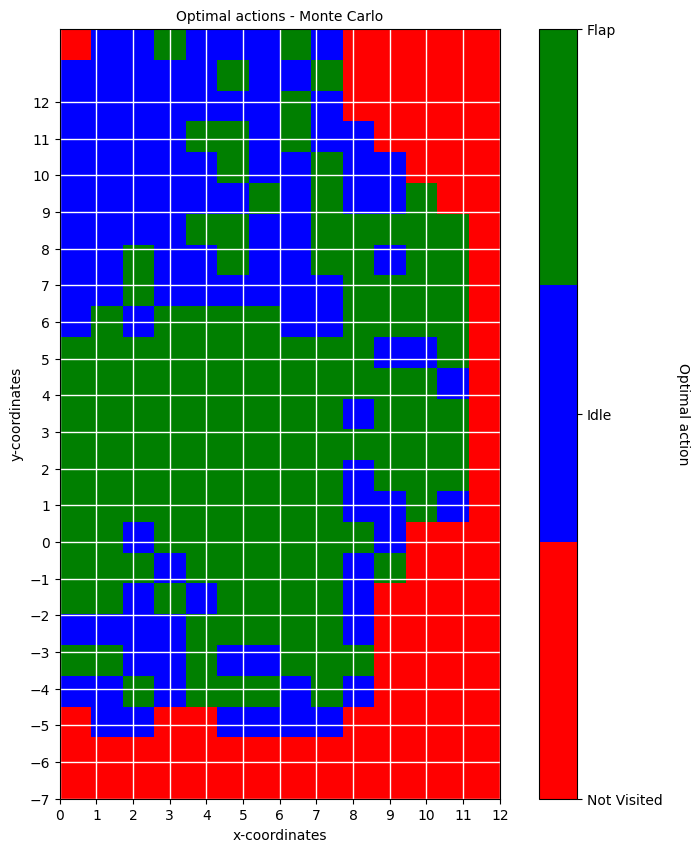

In [ ]:
# Get the range of x/y-axis for the plot
x_values_MC = []
y_values_MC = []
for state in mc_agent.Q.keys():
    x = state[0][0]
    y = state[0][1]
    if x not in x_values_MC:
        x_values_MC.append(x)
    if y not in y_values_MC:
        y_values_MC.append(y)

# Prepare the plot
x_range = sorted(x_values_MC)
y_range = sorted(y_values_MC)

# Calculate the optimal action for each state on the grid
optimal_actions = np.array([[get_optimal_action(x, y, mc_agent.Q) for x in x_range] for y in y_range])

# Generate the plot
plt.figure(figsize=(10, 10))
plt.xticks(x_range)
plt.yticks(y_range)
cmap = ListedColormap(['r','b', 'g'])  # Red for idle, green for flap
plt.imshow(optimal_actions, cmap=cmap, extent=[0, 12, -7, 14])
plt.title('Optimal actions - Monte Carlo', fontsize='medium')
plt.xlabel('x-coordinates')
plt.ylabel('y-coordinates')
plt.grid(color='w', linestyle='-', linewidth=1)
cbar = plt.colorbar(ticks=[-1,0, 1])
cbar.ax.set_yticklabels(['Not Visited','Idle', 'Flap'])
cbar.ax.set_ylabel('Optimal action', rotation=270, labelpad=20)
plt.show()

#Sarsa Lambda Implementation

In [78]:

from tqdm import tqdm
import random

class SARSALambdaAgent:
    def __init__(self,env, lambda_=0.1 , alpha=0.1, gamma=0.99, eps=0.4):


        # Set the agent parameters
        self.env= env
        self.lambda_ = lambda_
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = eps

        # Retrieve the action space of the agent (2 : flap, idle)
        self.action_space = env.action_space.n

        self.max_dx = env.observation_space[0].n # max horizontal observation space
        self.max_dy = env.observation_space[1].n + 3 # max vertical observation space, accounting 0
        self.min_dy = env.observation_space[1].start - 1 # min vertical observation space, plus minus 12


        # Retrieve number of states
        self.num_states = (self.max_dx) * (self.max_dy) # number of states = 322

        # Retrieve dimensions
        self.dims = env.observation_space[0].n, env.observation_space[1].n


        self.prev_state = None
        self.prev_action = None

        # Init q table and eligibility trace
        self.q_table = np.zeros((self.num_states, self.action_space))
        self.z_table = np.zeros((self.num_states, self.action_space))  # Eligibility traces


        self.eps_decay = 0.9999
        self.eps_min = 0.0001

        self.rand_generator = np.random.RandomState(42)


    def flatten_state(self,state):
        np_state = (state[1] + abs(self.min_dy)) * self.max_dx + state[0]
        return np_state

    def argmax(self, q_values):
        """ argmax with random tie-breaking
        Args:
            q_values (np array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

    def policy(self, state):
        # epsilon-greedy policy
        state = self.flatten_state(state)
        if np.random.random() < self.epsilon:
            return random.randint(0, self.env.action_space.n - 1)
        else:
            return self.argmax(self.q_table[state])

    def start(self,state):
        """ initiates Sarsa lambda agent
        Args:
            state (np array): the array of bird state dx and dy
        Returns:
            action (int): an action with the highest value
        """
        action = self.policy(state)

        self.prev_state = self.flatten_state(state)
        self.prev_action = action
        self.z_table.fill(0)

        return action

    def step(self,state, action, reward):
        """ applies Sarsa lambda algorithm
        Args:
            state (np array): the array of bird state dx and dy
            action (np array): the next action
            reward (int): the reward of next action
        """
        next_state = self.flatten_state(state)
        delta = reward + self.gamma * self.q_table[next_state][action] - self.q_table[self.prev_state][self.prev_action]

        self.z_table[self.prev_state][self.prev_action] += 1

        self.q_table += self.alpha * delta * self.z_table
        self.z_table *= self.gamma * self.lambda_

        self.prev_state = next_state
        self.prev_action = action

    def end(self,reward):
        """ applies Sarsa lambda algorithm at the end
        Args:
            reward (int): the reward of last action
        """
        delta = reward - self.q_table[self.prev_state][self.prev_action]

        self.q_table[self.prev_state][self.prev_action] += self.alpha * delta * self.z_table[self.prev_state][self.prev_action]
        self.z_table *= self.gamma * self.lambda_

        self.epsilon = max(self.eps_decay*self.epsilon, self.eps_min)
    def state_value_meshgrid(self):
       """Compute the state value function and return meshgrid coordinates"""
       state_values = np.zeros((self.max_dx, self.max_dy))
       meshgrid_x = np.arange(self.max_dx)
       meshgrid_y = np.arange(self.max_dy)
       for dx in range(self.max_dx):
        for dy in range(self.max_dy):
            state = (dx, dy)
            flattened_state = self.flatten_state(state)
            if flattened_state < len(self.q_table):
                state_values[dx][dy] = np.max(self.q_table[flattened_state])


       meshgrid_x, meshgrid_y = np.meshgrid(meshgrid_x, meshgrid_y)
       return meshgrid_x, meshgrid_y, state_values

    def state_value_function(self):
        """Compute the state value function from the Q-values"""
        state_values = np.zeros((self.max_dx, self.max_dy))

        for dx in range(self.max_dx):
            for dy in range(self.max_dy):
                state = (dx, dy)
                flattened_state = self.flatten_state(state)
                state_values[dx][dy] = np.max(self.q_table[flattened_state])

        return state_values

    def train(self):
      """ train the agent for self.num_episodes
      Returns:
          sarsa_episode_scores (list): an array of the score of each episode
      """
      # Variable initialization
      episode = 0
      score = 0
      episode_scores = []
      total_rewards = []

      # Set up a progress bar
      pbar = tqdm(total=EPISODES, desc="Training Progress",position=0, leave=True)


      for episode in range(EPISODES):
          # Intialize for new episode
          state, _ = self.env.reset()  # Reset environment for a new episode

          #self.start_episode()
          state[0]
          state[1]
          action =  self.start(state)# Start the episode with an initial action
          rewards = []

          done = False # Play until done (agent lost)

          while not done:
              # Interact with the environment and observe reward and next state
              next_state, reward, done, _, info = self.env.step(action)
              rewards.append(reward)


              # Update SARSA agent based on observed reward and transition
              next_action = self.policy(next_state)  # Select next action using agent's policy

              if not done:
                  self.step(state, action, reward)

              state,action = next_state,next_action

          self.end(reward)
          score = info['score']
          episode_scores.append(score)
          total_rewards.append(sum(rewards))
          global_average_score = sum(episode_scores)/len(episode_scores)

          # Update the progress bar
          pbar.update(1)
          pbar.set_postfix({
            'Total reward': sum(rewards),
            'Score': score,
            'Average score':global_average_score,
            'Exporation rate':self.epsilon
          })

      return episode_scores, total_rewards
    def test(self, episodes=100):
      """Test the trained agent without updating Q-values"""
      # Variable initialization
      episode = 0
      episode_scores = []
      total_rewards = []

      # Set up a progress bar
      pbar = tqdm(total=episodes, desc="Testing Progress", position=0, leave=True)

      for episode in range(episodes):
        # Intialize for new episode
        state, _ = self.env.reset()  # Reset environment for a new episode

        # Start the episode with an initial action
        action = self.start(state)
        rewards = []

        done = False  # Play until done (agent lost)

        while not done:
            # Interact with the environment and observe reward and next state
            next_state, reward, done, _, info = self.env.step(action)
            rewards.append(reward)

            # Select next action using agent's policy
            next_action = self.policy(next_state)

            # Update state and action for the next step
            state, action = next_state, next_action

        # Record score and total rewards
        score = info['score']
        episode_scores.append(score)
        total_rewards.append(sum(rewards))

        # Update the progress bar
        pbar.update(1)
        pbar.set_postfix({
            'Total reward': sum(rewards),
            'Score': score,
            'Average score': np.mean(episode_scores)
        })

      return episode_scores, total_rewards

In [70]:
env = gym.make('TextFlappyBird-v0')  # create your environment here
agent = SARSALambdaAgent(env,lambda_=0.1 , alpha=0.1, gamma=0.99, eps=0.4)

EPISODES = 1000  # set the number of episodes for training
scores, total_rewards = agent.train()

Training Progress: 100%|██████████| 1000/1000 [00:03<00:00, 256.97it/s, Total reward=14, Score=0, Average score=0.657, Exporation rate=0.362]


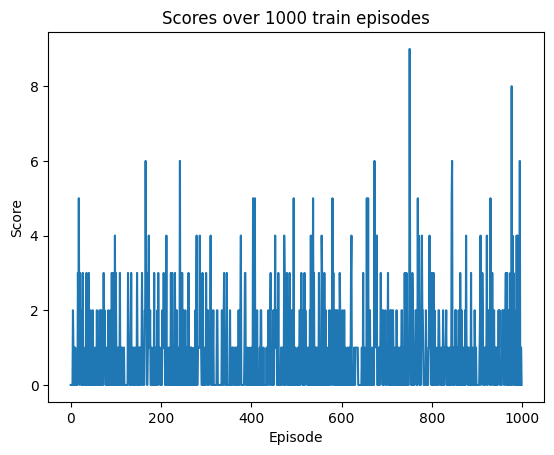

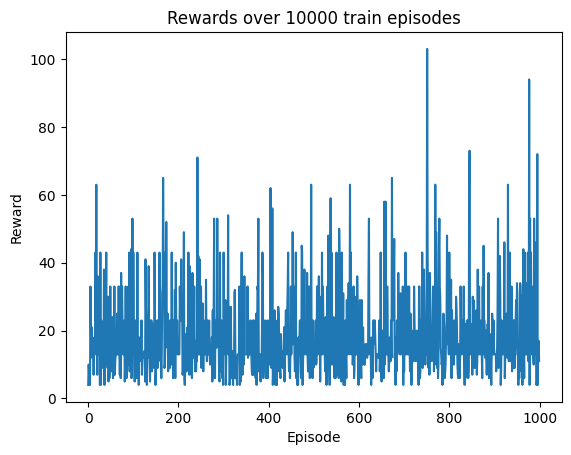

In [23]:
# plot the scores
plt.plot(scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {EPISODES} train episodes")
plt.show()


# plot the rewards
plt.plot(total_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} train episodes")
plt.show()

#Hyperparameter Tuning for Sarsa Lambda

In [25]:
labels = ["epsilon = 0.1", "epsilon = 0.2","epsilon = 0.3", "epsilon = 0.4","epsilon = 0.5", "epsilon = 0.6", "epsilon = 0.7"]
epsilon = [0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.7]



all_scores=[]
all_rewards=[]
for eps in epsilon:
    n_episodes = 10000



    # train the Monte Carlo agent
    train_scores, train_rewards = agent.train()
    all_scores.append(train_scores)
    all_rewards.append(train_rewards)

Training Progress: 100%|██████████| 1000/1000 [00:05<00:00, 176.62it/s, Total reward=37, Score=3, Average score=2.17, Exporation rate=0.18]


In [26]:
# Define the number of rows and columns
num_rows = len(labels)
num_cols = 2

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10*num_rows))

# Plot the scores and rewards for each row
for i in range(num_rows):
    # Plot the scores
    axs[i, 0].plot(all_scores[i])
    axs[i, 0].set_xlabel("Episodes")
    axs[i, 0].set_ylabel("Scores", rotation=0, labelpad=40)
    axs[i, 0].set_title(labels[i])
     #Plot the rewards
    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("Episodes")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])


# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plots
plt.show()

In [27]:
labels = ["Gamma = 0.5", "Gamma = 0.6", "Gamma = 0.7","Gamma = 0.8","Gamma = 0.9","Gamma = 0.9999"]
gamma = [0.5, 0.6, 0.7,0.8,0.9,0.9999]



all_scores=[]
all_rewards=[]
for gam in gamma:
    n_episodes = 10000



    train_scores, train_rewards = agent.train()
    all_scores.append(train_scores)
    all_rewards.append(train_rewards)

Training Progress: 100%|██████████| 1000/1000 [00:06<00:00, 152.31it/s, Total reward=33, Score=2, Average score=4.99, Exporation rate=0.0986]


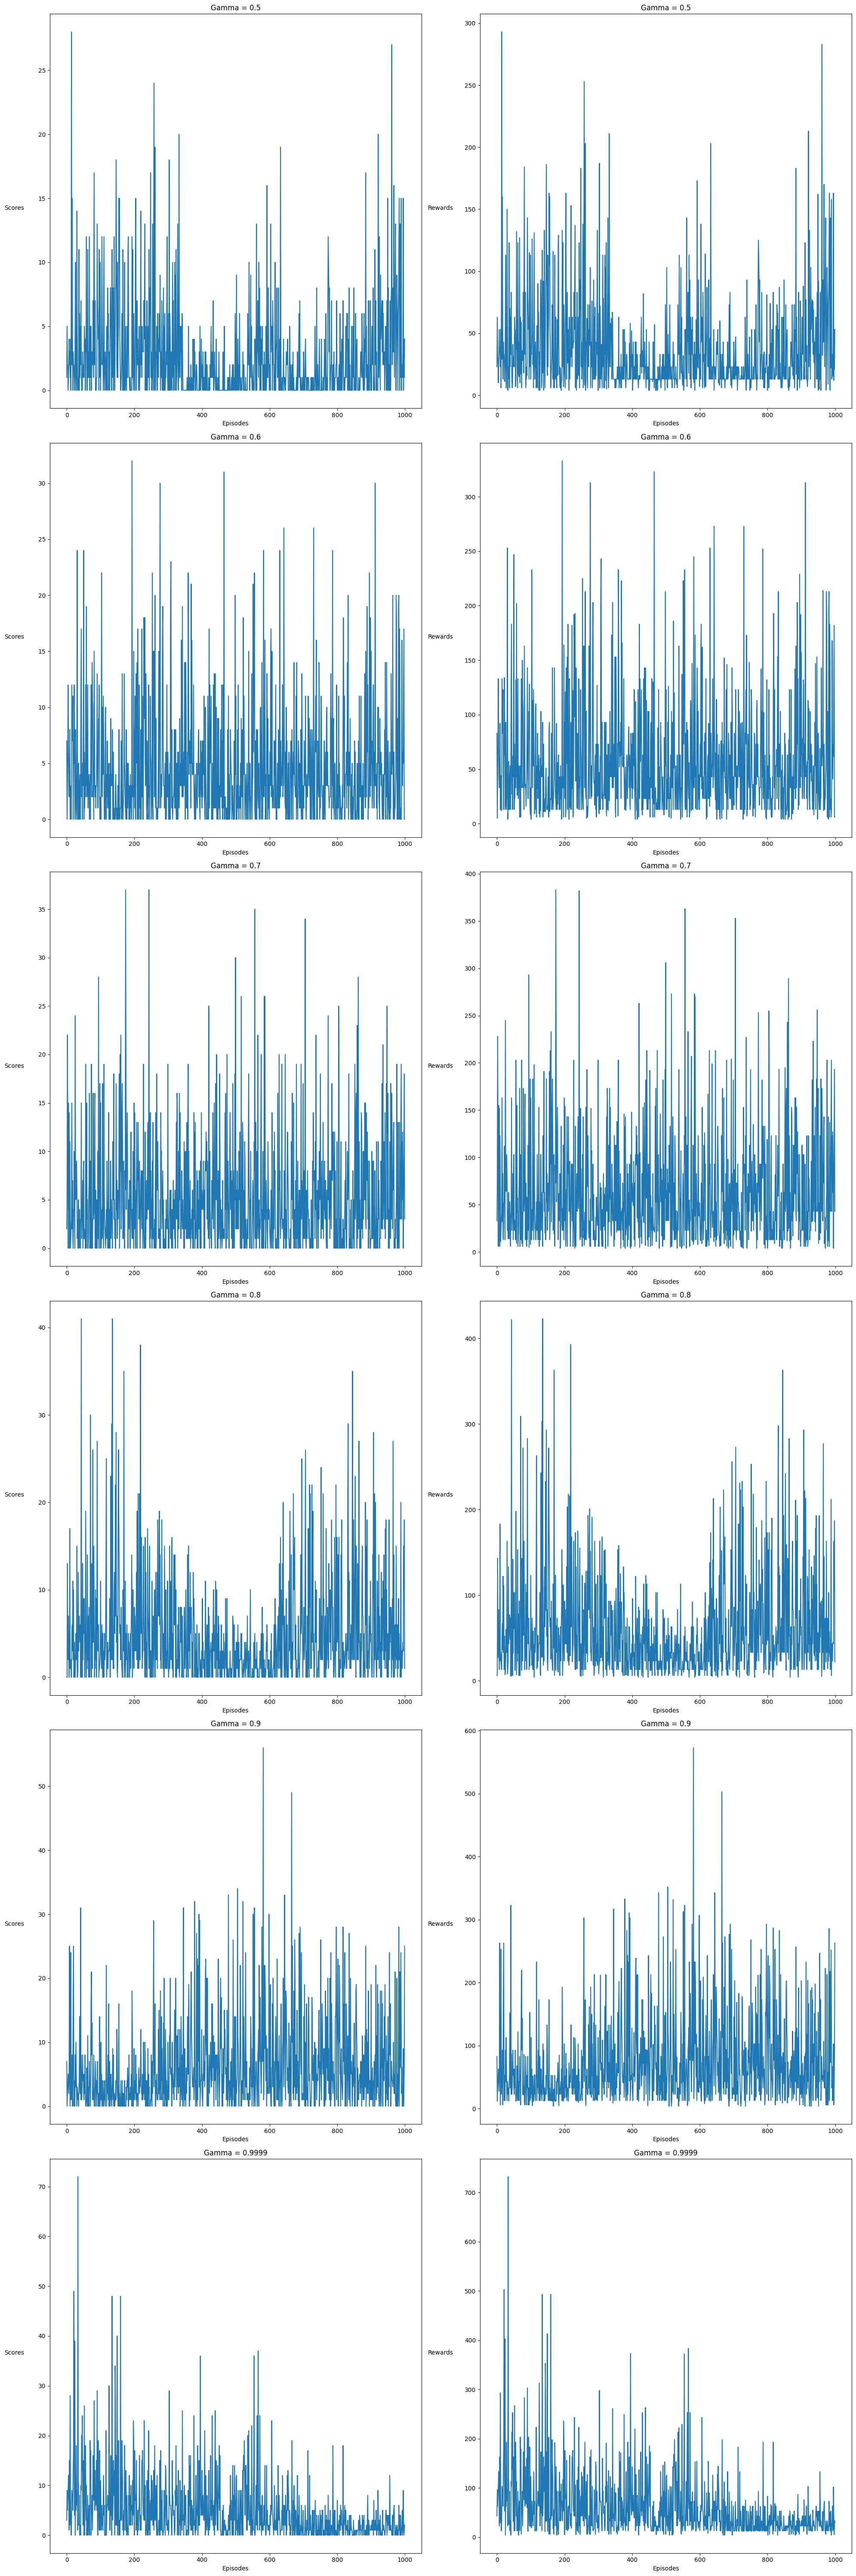

In [28]:
# Define the number of rows and columns
num_rows = len(labels)
num_cols = 2

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10*num_rows))

# Plot the scores and rewards for each row
for i in range(num_rows):
    # Plot the scores
    axs[i, 0].plot(all_scores[i])
    axs[i, 0].set_xlabel("Episodes")
    axs[i, 0].set_ylabel("Scores", rotation=0, labelpad=40)
    axs[i, 0].set_title(labels[i])

    # Plot the rewards
    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("Episodes")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plots
plt.show()

In [29]:
labels = ["Alpha = 0.01", "Gamma = 0.1", "Gamma = 0.5","Gamma = 0.8","Gamma = 0.9","Gamma = 0.9999"]
alpha = [0.01, 0.1, 0.5,0.8,0.9,0.9999]



all_scores=[]
all_rewards=[]
for alp in alpha:
    n_episodes = 10000



    train_scores, train_rewards = agent.train()
    all_scores.append(train_scores)
    all_rewards.append(train_rewards)

Training Progress: 100%|██████████| 1000/1000 [00:09<00:00, 104.86it/s, Total reward=23, Score=1, Average score=8.82, Exporation rate=0.0541]


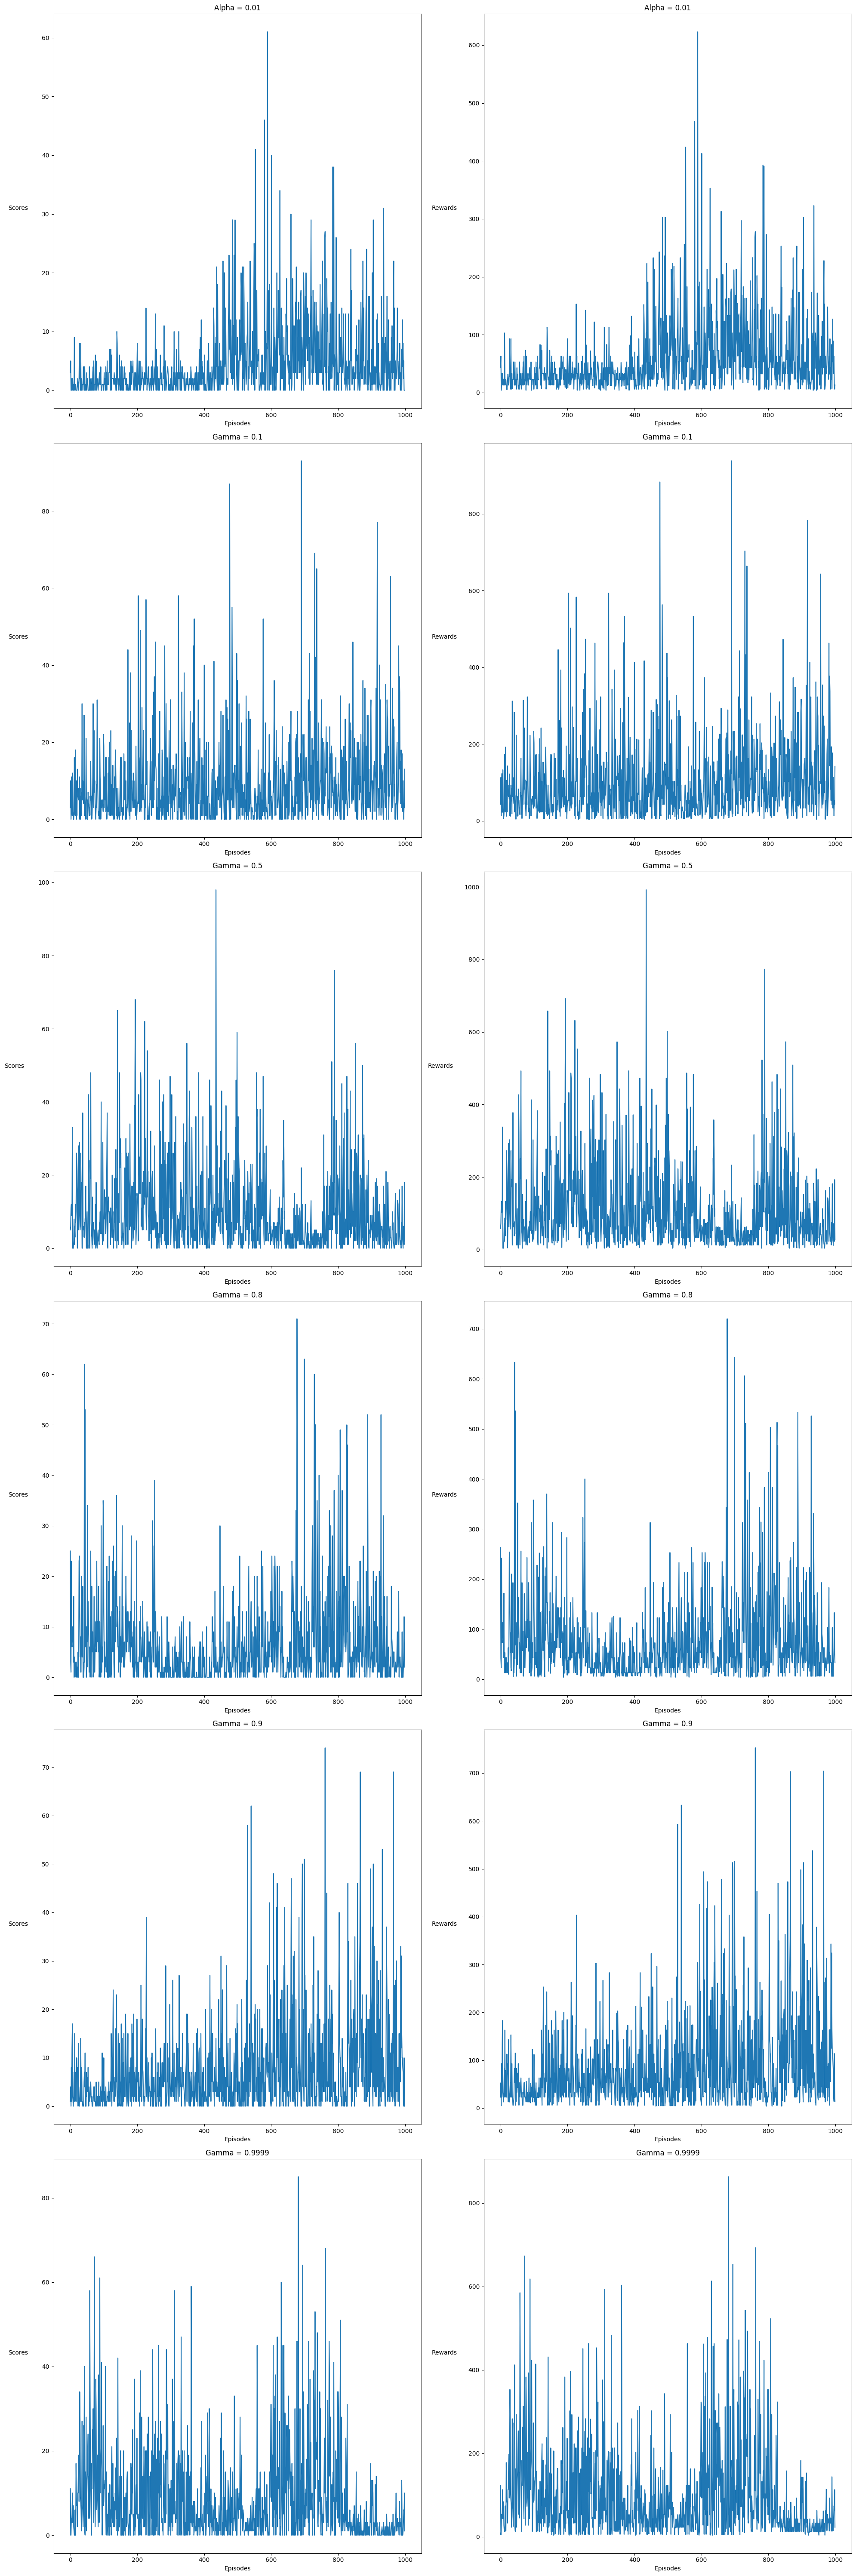

In [30]:
# Define the number of rows and columns
num_rows = len(labels)
num_cols = 2

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10*num_rows))

# Plot the scores and rewards for each row
for i in range(num_rows):
    # Plot the scores
    axs[i, 0].plot(all_scores[i])
    axs[i, 0].set_xlabel("Episodes")
    axs[i, 0].set_ylabel("Scores", rotation=0, labelpad=40)
    axs[i, 0].set_title(labels[i])

    # Plot the rewards
    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("Episodes")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plots
plt.show()

In [31]:
labels = ["Lambda = 0.01", "Lambda = 0.1", "Lambda = 0.5","Lambda = 0.8","Lambda = 0.9","Lambda = 0.9999"]
lambda_ = [0.01, 0.1, 0.5,0.8,0.9,0.9999]



all_scores=[]
all_rewards=[]
for lam in lambda_:
    n_episodes = 10000



    train_scores, train_rewards = agent.train()
    all_scores.append(train_scores)
    all_rewards.append(train_rewards)

Training Progress: 100%|██████████| 1000/1000 [00:10<00:00, 96.03it/s, Total reward=13, Score=0, Average score=11.2, Exporation rate=0.0297] 


#Best Parameters Found
Epsilon=0.5,
Gamma=0.9,
Alpha=0.1,
Lambda=0.01


Training Progress: 100%|██████████| 20000/20000 [01:49<00:00, 182.92it/s, Total reward=12, Score=0, Average score=2.23, Exporation rate=0.0677]


Average reward over 20000 train episodes: 33.96745
Median reward over 20000 train episodes: 23.0
Average scores over 20000 train episodes: 2.22645
Median scores over 20000 train episodes: 1.0


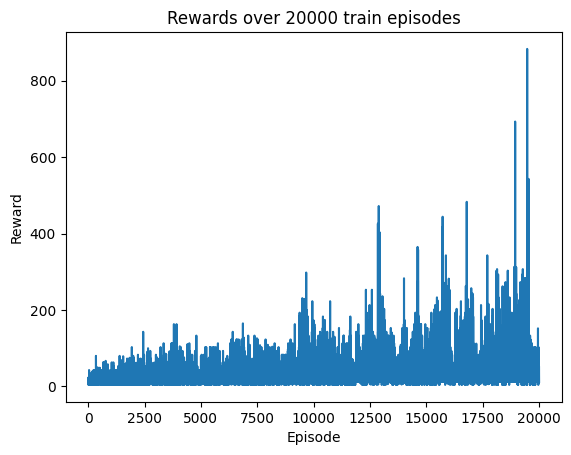

In [79]:
EPISODES = 20000
# create the Best Sarsa Lambda agent
agent = SARSALambdaAgent(env,lambda_=0.01 , alpha=0.1, gamma=0.9, eps=0.5)

# train the Monte Carlo agent
train_scores, train_rewards = agent.train()

print(f"Average reward over {EPISODES} train episodes:", np.mean(train_rewards))
print(f"Median reward over {EPISODES} train episodes:", np.median(train_rewards))
print(f"Average scores over {EPISODES} train episodes:", np.mean(train_scores))
print(f"Median scores over {EPISODES} train episodes:", np.median(train_scores))


# plot the rewards
plt.plot(train_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {EPISODES} train episodes")
plt.show()

# plot the scores
plt.plot(train_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {EPISODES} train episodes")
plt.show()

Testing Progress: 100%|██████████| 100/100 [00:00<00:00, 277.71it/s, Total reward=13, Score=0, Average score=0.17]


Average reward over 100 test episodes: 14.47
Median reward over 100 test episodes: 13.0
Average scores over 100 test episodes: 0.17
Median scores over 100 test episodes: 0.0


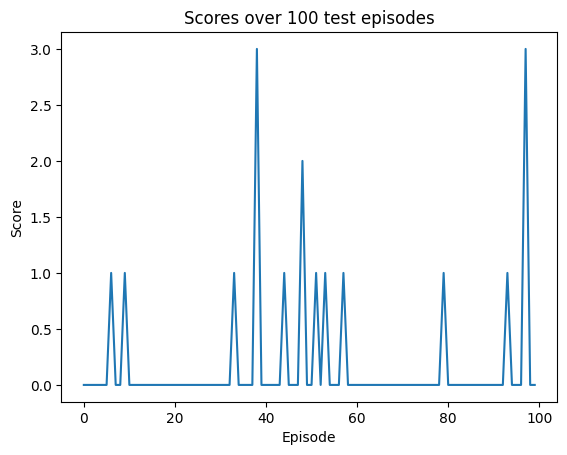

In [45]:
n_episodes=100
test_scores,test_rewards = agent.test()
print(f"Average reward over {n_episodes} test episodes:", np.mean(test_rewards))
print(f"Median reward over {n_episodes} test episodes:", np.median(test_rewards))
print(f"Average scores over {n_episodes} test episodes:", np.mean(test_scores))
print(f"Median scores over {n_episodes} test episodes:", np.median(test_scores))


# plot the rewards
plt.plot(test_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} test episodes")
plt.show()

# plot the scores
plt.plot(test_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} test episodes")
plt.show()

In [55]:
# Set up a list of episodes to test
num_episodes_list = [1000, 2000, 3000, 4000, 5000]

# Set up a list to store the average scores/rewards
avg_scores = []
avg_rewards= []

# Loop through each episode count
for num_episodes in num_episodes_list:

    # Test the agent on the test set
    test_scores,test_rewards = agent.test()

    # Calculate the average score for the test set
    avg_score = np.mean(test_scores)
    avg_reward = np.mean(test_rewards)

    # Add the average score/reward to the list
    avg_scores.append(avg_score)
    avg_rewards.append(avg_reward)

Testing Progress: 100%|██████████| 100/100 [00:00<00:00, 237.83it/s, Total reward=12, Score=0, Average score=1.55]


#Parameter Sweep Graphs for Sarsa Lambda

In [56]:
# Plot the parameter sweep graph
plt.plot(num_episodes_list, avg_scores)
# plt.plot(num_episodes_list, avg_rewards)
plt.xlabel("Number of Episodes during Training")
plt.ylabel("Average Score on Test Set")
plt.title("Impact of Number of Episodes during Training on Sarsa Lambda Agent Performance", pad=20)
plt.show()

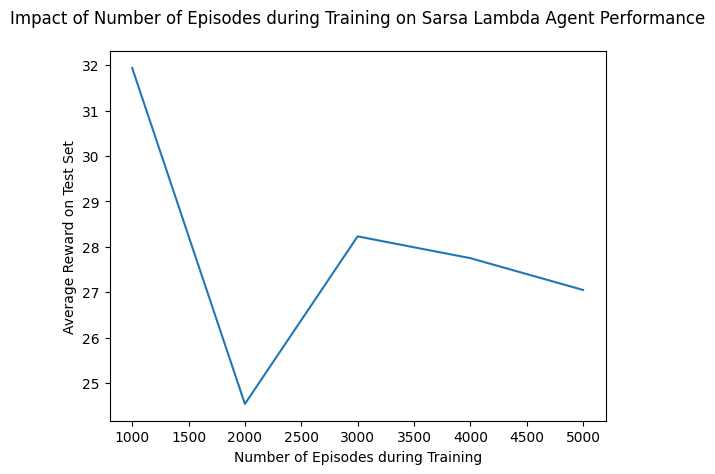

In [57]:
# Plot the parameter sweep graph
plt.plot(num_episodes_list, avg_rewards)
plt.xlabel("Number of Episodes during Training")
plt.ylabel("Average Reward on Test Set")
plt.title("Impact of Number of Episodes during Training on Sarsa Lambda Agent Performance", pad=20)
plt.show()

In [51]:
# Set up a list of pipe gap to test
pipe_gap_list = [1, 2, 3,4,5,6,7]

# Set up a list to store the average scores/rewards
avg_scores = []
avg_rewards= []

# Train the MC agent on a training environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
agent = SARSALambdaAgent(env,lambda_=0.01 , alpha=0.1, gamma=0.9, eps=0.5)
agent.train()

# Loop through each pipe gap
for pipe_gap in pipe_gap_list:

    # Initialize the environment with the pipe gap
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=pipe_gap)

    # Test the agent on the test set
    test_scores,test_rewards = agent.test()

    # Calculate the average score for the test set
    avg_score = np.mean(test_scores)
    avg_reward = np.mean(test_rewards)

    # Add the average score/reward to the list
    avg_scores.append(avg_score)
    avg_rewards.append(avg_reward)

Testing Progress: 100%|██████████| 100/100 [00:00<00:00, 238.54it/s, Total reward=23, Score=1, Average score=1.77]


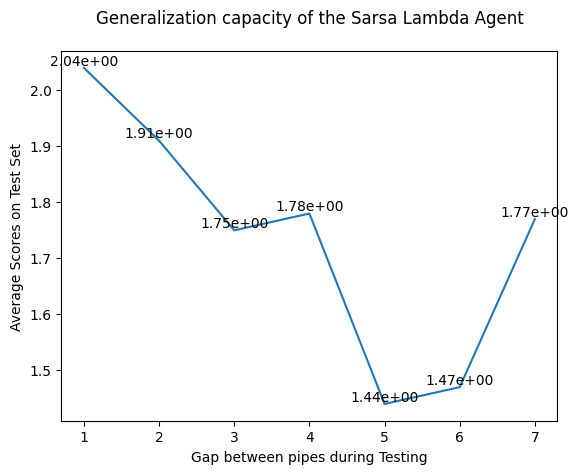

In [53]:
# Plot the parameter sweep graph
plt.plot(pipe_gap_list, avg_scores)
plt.xlabel("Gap between pipes during Testing")
plt.ylabel("Average Scores on Test Set")
plt.title("Generalization capacity of the Sarsa Lambda Agent", pad=20)

# Add value for each point
for x, y in zip(pipe_gap_list, avg_scores):
    plt.text(x, y, f"{y:.2e}", ha="center", va="bottom")


plt.show()

#State Value function for Sarsa Lambda using Meshgrid

In [83]:
def plot_state_values(meshgrid_x, meshgrid_y, state_values):
    """Plot the state values as a 2D meshgrid"""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(meshgrid_x, meshgrid_y, state_values.T, cmap='viridis')  # Transpose state_values
    ax.set_xlabel('dx')
    ax.set_ylabel('dy')
    ax.set_zlabel('State Value')
    plt.title('State Value Function')
    plt.show()


Training Progress:   8%|▊         | 1637/20000 [37:41<7:02:50,  1.38s/it, Total reward=24, Score=1, Average score=0.758, Exporation rate=0.424]


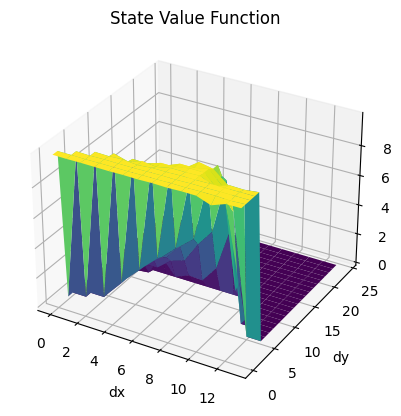

In [84]:
meshgrid_x, meshgrid_y, state_values = agent.state_value_meshgrid()
plot_state_values(meshgrid_x, meshgrid_y,state_values)